# 1. **Introdução**

Este notebook tem como objetivo desenvolver e avaliar modelos preditivos capazes de estimar a probabilidade de diferentes faixas de gols em partidas da Premier League, a principal liga de futebol da Inglaterra. Utilizando dados estatísticos das últimas cinco temporadas, são aplicados algoritmos de aprendizado de máquina supervisionado — como Regressão Logística, Random Forest e XGBoost — para classificar os jogos conforme o número total de gols. A eficácia dos modelos é mensurada por meio de métricas como Acurácia, Recall, F1-Score e ROC-AUC. Os resultados obtidos não apenas destacam o potencial dessas técnicas para análise de desempenho esportivo, como também oferecem subsídios relevantes para aplicações em estratégias táticas e apostas esportivas.

## 📌 Sumário

- [1. Introdução](#1-introdução)
- [2. Importação de bibliotecas](#2-importação-de-bibliotecas)
- [3. Carregamento dos dados](#3-carregamento-dos-dados)
- [4. Preparação e seleção das features](#4-preparação-e-seleção-das-features)
  - [4.1 - Preparação das features](#41---preparação-das-features)
  - [4.2 - Seleção das Features](#42---seleção-das-features)
    - [4.2.1 - Seleção combinada de atributos com CFIS (Combined Feature Importance Score)](#421---seleção-combinada-de-atributos-com-cfis-combined-feature-importance-score)
    - [4.2.2 - Filtro de atributos com base na importância](#422---filtro-de-atributos-com-base-na-importância)
- [5. Tratamento e Balanceamento dos dados](#5-tratamento-e-balanceamento-dos-dados)
  - [5.1 - Redução de dimensionalidade e normalização](#51---redução-de-dimensionalidade-e-normalização)
    - [5.1.1 - Distribuição de gols por partida](#511---distribuição-de-gols-por-partida)
  - [5.2 - Balancemento](#52---balancemento)
    - [5.2.1 - Distribuição das classes após o balanceamento (SMOTE)](#521---distribuição-das-classes-após-o-balanceamento-smote)
- [6. Divisão dos dados em treino e teste](#6-divisão-dos-dados-em-treino-e-teste)
  - [6.1 - Avaliação dos modelos preditivos](#61---avaliação-dos-modelos-preditivos)
  - [6.2 - Treinamento e avaliação dos modelos](#62---treinamento-e-avaliação-dos-modelos)
- [7. Transformação da tabela de resultados para formato longo](#7-transformação-da-tabela-de-resultados-para-formato-longo)
- [8. Comparação visual entre os modelos](#8-comparação-visual-entre-os-modelos)
- [9. Conclusão](#9-conclusão)


# 2. **Importação de bibliotecas**

In [1]:
pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import label_binarize
warnings.filterwarnings("ignore", category=UserWarning)

# 3. **Carregamento dos dados**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Carregar dados
df = pd.read_csv("all_seasons.csv")
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,09/08/2019,20:00,Liverpool,Norwich,4,1,H,4,0,...,3.43,-2.25,1.91,1.99,1.94,1.98,1.99,2.07,1.90,1.99
1,E0,10/08/2019,12:30,West Ham,Man City,0,5,A,0,1,...,2.91,1.75,1.95,1.95,1.96,1.97,2.07,1.98,1.97,1.92
2,E0,10/08/2019,15:00,Bournemouth,Sheffield United,1,1,D,0,0,...,1.92,-0.50,1.95,1.95,1.98,1.95,2.00,1.96,1.96,1.92
3,E0,10/08/2019,15:00,Burnley,Southampton,3,0,H,0,0,...,1.71,0.00,1.87,2.03,1.89,2.03,1.90,2.07,1.86,2.02
4,E0,10/08/2019,15:00,Crystal Palace,Everton,0,0,D,0,0,...,1.71,0.25,1.82,2.08,1.97,1.96,2.03,2.08,1.96,1.93


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Columns: 106 entries, Div to AvgCAHA
dtypes: float64(82), int64(16), object(8)
memory usage: 1.5+ MB


In [ ]:
# Criar variável-alvo multi-classe
#df['total_goals'] = df['FTHG'] + df['FTAG']

#def goal_class(g):
#    if g == 0:
#        return 0
#    elif g == 1:
#        return 1
#   elif g == 2:
#        return 2
#    else:
#        return 3

#df['goal_class'] = df['total_goals'].apply(goal_class)

## 4. **Preparação e seleção das features**


## 4.1 - **Preparação das features**

Este trecho, é criada a variável goal_class, que representa a quantidade total de gols em uma partida, categorizada em quatro faixas. Primeiramente, somam-se os gols marcados pelo time mandante (FTHG) e pelo visitante (FTAG), armazenando o resultado na coluna total_goals.

Em seguida, define-se a função goal_class(g), que classifica esse total de gols nas seguintes categorias:

Classe 0: jogos com 0 gols

Classe 1: jogos com exatamente 1 gol

Classe 2: jogos com exatamente 2 gols

Classe 3: jogos com 3 ou mais gols.

Essa categorização é aplicada a todo o dataset por meio da função apply, resultando na nova variável goal_class, que será usada como alvo (target) nos modelos de classificação multiclasse.

In [10]:
# Criando a variável alvo
df['total_goals'] = df['FTHG'] + df['FTAG']
# Criando classes para a variável alvo
df['goal_class'] = df['total_goals'].apply(lambda g: g if g < 3 else 3)

In [8]:
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,total_goals,goal_class
0,E0,09/08/2019,20:00,Liverpool,Norwich,4,1,H,4,0,...,1.91,1.99,1.94,1.98,1.99,2.07,1.90,1.99,5,3
1,E0,10/08/2019,12:30,West Ham,Man City,0,5,A,0,1,...,1.95,1.95,1.96,1.97,2.07,1.98,1.97,1.92,5,3
2,E0,10/08/2019,15:00,Bournemouth,Sheffield United,1,1,D,0,0,...,1.95,1.95,1.98,1.95,2.00,1.96,1.96,1.92,2,2
3,E0,10/08/2019,15:00,Burnley,Southampton,3,0,H,0,0,...,1.87,2.03,1.89,2.03,1.90,2.07,1.86,2.02,3,3
4,E0,10/08/2019,15:00,Crystal Palace,Everton,0,0,D,0,0,...,1.82,2.08,1.97,1.96,2.03,2.08,1.96,1.93,0,0


In [9]:
df.dtypes

,0
Div,object
Date,object
Time,object
HomeTeam,object
AwayTeam,object
...,...
MaxCAHA,float64
AvgCAHH,float64
AvgCAHA,float64
total_goals,int64


In [ ]:
# Verificando as colunas string
text = df.select_dtypes(include=['object']).columns
text

Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTR', 'HTR', 'Referee'], dtype='object')

In [ ]:
# Verificando as colunas numéricas
numeric = df.select_dtypes(include=['float64', 'int64']).columns
numeric

Index(['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF',
       'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH',
       'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD',
       'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD',
       'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5',
       'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA',
       'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA',
       'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA',
       'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD',
       'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5',
       'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh',
       'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA',
       'AvgCAHH', 'AvgCAHA', 'total_goals', 'goal_class'],
      dtype='object')

In [ ]:
# Selecionar as colunas
#teams = df[['HomeTeam', 'AwayTeam']]

# One-hot encoding
#encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' evita multicolinearidade
#encoded_teams = encoder.fit_transform(teams)

# Nomes das colunas
#encoded_cols = encoder.get_feature_names_out(['HomeTeam', 'AwayTeam'])

# Converter para DataFrame e concatenar
#encoded_df = pd.DataFrame(encoded_teams, columns=encoded_cols, index=df.index)
#df = pd.concat([df, encoded_df], axis=1)

## 4.2 - **Seleção das features**


Nesta etapa, foram selecionadas apenas as variáveis numéricas do conjunto de dados para compor a matriz de atributos (X), excluindo-se as colunas diretamente relacionadas à variável-alvo (FTHG, FTAG, total_goals e goal_class), a fim de evitar vazamento de dados no treinamento dos modelos. A variável-alvo (y) foi definida como a coluna goal_class, que representa a faixa de gols da partida.

Em seguida, os valores ausentes presentes em X foram tratados por meio da imputação da média de cada coluna, garantindo um conjunto de dados completo e apropriado para os algoritmos de aprendizado de máquina.

Por fim, os nomes das colunas de X foram padronizados para remover caracteres especiais ([, ], <) e substituir espaços por underscores (_). Essa padronização é importante para garantir compatibilidade com bibliotecas como scikit-learn e xgboost, além de facilitar a manipulação dos dados ao longo do pipeline analítico.


In [ ]:
# Selecionar features numéricas e tratar nulos
X = df.select_dtypes(include=['float64', 'int64']).drop(columns=['FTHG', 'FTAG', 'total_goals', 'goal_class'])
y = df['goal_class']
X = X.fillna(X.mean())

In [ ]:
# Corrigir nomes
X.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace(' ', '_') for col in X.columns]

In [ ]:
y.head()

,goal_class
0,3
1,3
2,2
3,3
4,0


### 4.2.1 - **Seleção combinada de atributos com CFIS (Combined Feature Importance Score)**
Neste bloco, é aplicada uma abordagem híbrida de seleção de atributos utilizando múltiplos critérios para identificar as variáveis mais relevantes na previsão de faixas de gols.

A função combined_feature_selection() realiza os seguintes passos:

Treinamento do modelo base: um modelo de Regressão Logística é ajustado sobre os dados (X, y) para servir de base na análise de importância.

Permutation Importance: calcula a importância de cada feature ao embaralhar seus valores e mensurar o impacto na performance do modelo. Os valores são normalizados para que a soma seja igual a 1.

Coeficientes do modelo: os coeficientes gerados pela regressão logística são extraídos e normalizados via norma L2.

Correlação com a variável-alvo: para cada feature, calcula-se a correlação com y, utilizando o coeficiente de Pearson.

CFIS (Combined Feature Importance Score): é calculada a média entre os três critérios — Permutation Importance, Coeficiente e Correlação — formando uma métrica agregada. Esse valor também é normalizado para obter a contribuição percentual de cada variável.

Visualização dos resultados: os scores são organizados em um DataFrame e ordenados de forma decrescente. A coluna CFIS recebe destaque visual com coloração condicional: valores positivos são destacados em verde claro e negativos em vermelho claro. A coluna CFIS (%) exibe a importância relativa de cada variável em porcentagem.

In [ ]:
def combined_feature_selection(df):

    # Inicializar o modelo de regressão logística
    logreg = LogisticRegression()
    logreg.fit(X, y)

    # Calcular a importância das features usando Permutation Importance
    result = permutation_importance(logreg, X, y, n_repeats=10, random_state=42)

    # Coletar as importâncias das features
    importances_permutation = result.importances_mean

    # Normalizar as importâncias das features para que a soma seja igual a 1
    normalized_importances_permutation = importances_permutation / np.sum(importances_permutation)

    # Coletar os coeficientes do modelo após o ajuste
    coefficients = logreg.coef_[0]

    # Normalizar os coeficientes
    normalized_coefficients = coefficients / np.linalg.norm(coefficients)

    # Calcular a correlação entre as features e a variável alvo
    correlation_scores = X.apply(lambda feature: feature.corr(y))

    # Calcular o CFIS como a média das métricas de importância, coeficientes e correlações
    combined_score = (normalized_importances_permutation + normalized_coefficients + correlation_scores) / 3

    # Normalizar as pontuações CFIS para que a soma seja igual a 100
    cfis_percentage = (combined_score / np.sum(combined_score)) * 100

    # Criar um DataFrame com as features e suas pontuações de Permutation Importance, coeficientes, correlações,
    # pontuações combinadas e porcentagens de importância CFIS
    feature_scores = pd.DataFrame({
        'Permutation Importance': normalized_importances_permutation,
        'Coefficient': coefficients,
        'Correlation': correlation_scores,
        'CFIS': combined_score,
        'CFIS (%)': cfis_percentage
    }, index=X.columns)

    # Ordenar os resultados de acordo com o CFIS em ordem decrescente
    sorted_features = feature_scores.sort_values(by='CFIS', ascending=False)

    # Formatar a coluna CFIS para destacar com uma cor diferente
    def highlight_cfis(value):
        if value > 0:
            return 'background-color: lightgreen'
        elif value < 0:
            return 'background-color: salmon'
        else:
            return ''

    # Aplicar a formatação de cores à coluna CFIS e ajustar a formatação da porcentagem
    sorted_features_styled = sorted_features.style.applymap(highlight_cfis, subset=['CFIS']).format({'CFIS (%)': '{:.2f}%'}).set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'left')]
    }])

    return sorted_features_styled

# Chamar a função com o dataframe df
sorted_features = combined_feature_selection(df)

# Exibir as features classificadas de acordo com a métrica CFIS
print("Features classificadas de acordo com a métrica CFIS(Combined Feature Importance Score):")
sorted_features

Features classificadas de acordo com a métrica CFIS(Combined Feature Importance Score):


<ipython-input-16-8c9bd6ad20a4>:54: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  sorted_features_styled = sorted_features.style.applymap(highlight_cfis, subset=['CFIS']).format({'CFIS (%)': '{:.2f}%'}).set_table_styles([{


,Permutation Importance,Coefficient,Correlation,CFIS,CFIS (%)
HST,0.106410,-0.238456,0.307956,0.080120,5.49%
MaxCA,0.044541,0.080565,0.096572,0.066634,4.57%
IWCD,-0.002977,0.093743,0.133926,0.066452,4.55%
P2.5,-0.000319,0.022635,0.181310,0.065836,4.51%
B3652.5,-0.002977,0.017570,0.181559,0.063801,4.37%
Avg2.5,-0.002126,0.010753,0.185556,0.063759,4.37%
MaxC2.5,-0.001382,0.001086,0.182896,0.060769,4.16%
AvgC2.5,-0.001913,-0.006211,0.188189,0.060581,4.15%
Max2.5,-0.006803,0.002945,0.186287,0.060544,4.15%
PC2.5,-0.001063,-0.011510,0.186414,0.058984,4.04%


In [ ]:
X.shape

(1900, 96)

### 4.2.2 - **Filtro de atributos com base na importância**
Para refinar o conjunto de atributos utilizados nos modelos, foi definida a função filtrar_por_importancia(), que remove variáveis com impacto considerado irrelevante — ou seja, com importância próxima de zero.

Funcionamento da função:

Entrada:

    X: DataFrame contendo as features originais.

    importancias: um objeto pd.Series com os valores de importância atribuídos a cada feature (por exemplo, provenientes do CFIS).

    limiar: um valor mínimo absoluto (default = 0.01) para considerar uma importância significativa, positiva ou negativa.

Critério de seleção:

    A função mantém apenas as colunas cujos valores de importância estejam acima de limiar ou abaixo de -limiar, descartando atributos com impacto marginal no modelo.

Saída:

    Um novo DataFrame X_filtrado, contendo somente as features relevantes.

Esse filtro contribui para a redução da dimensionalidade do conjunto de dados, eliminando variáveis ruidosas ou redundantes, e potencialmente melhora a performance e interpretabilidade dos modelos preditivos.



In [ ]:
def filtrar_por_importancia(X: pd.DataFrame, importancias: pd.Series, limiar: float = 0.01) -> pd.DataFrame:
    """
    Remove features com importância entre -limiar e limiar (ganho/perda irrelevante).

    Parâmetros:
    - X: DataFrame com as features.
    - importancias: Series com a importância das features (index = nomes das colunas).
    - limiar: valor mínimo de ganho ou perda considerado relevante (default = 0.01).

    Retorna:
    - X_filtrado: DataFrame apenas com features relevantes.
    """
    # Filtra: mantêm somente features com ganho ≥ limiar ou perda ≤ -limiar
    filtro = (importancias >= limiar) | (importancias <= -limiar)
    features_selecionadas = importancias[filtro].index
    return X[features_selecionadas]

Com base nos valores de CFIS, aplicou-se um filtro para manter apenas as features com importância absoluta maior ou igual a 0.01.

In [ ]:
cfis_series = sorted_features.data['CFIS']  # pega os dados reais
features = filtrar_por_importancia(X, cfis_series, limiar=0.01)

In [ ]:
features.shape

(1900, 68)

# 5. **Tratamento e Balanceamento dos dados**


## 5.1 - **Redução de dimensionalidade e normalização**

Nesta etapa, foram removidas as features com baixa variância (menor que 0.01), por meio do VarianceThreshold, eliminando variáveis que pouco contribuem para a distinção entre classes.

Em seguida, os dados foram normalizados com StandardScaler, padronizando as features para média 0 e desvio padrão 1

In [ ]:
# Remover features com baixa variância
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(features)

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

### 5.1.1 - **Distribuição de gols por partida**

Este gráfico de barras mostra a distribuição das partidas da Premier League de acordo com o total de gols marcados (variável goal_class). Ele permite visualizar a frequência com que ocorrem jogos com 0, 1, 2 ou 3+ gols, sendo útil para entender o balanceamento das classes no problema de classificação.

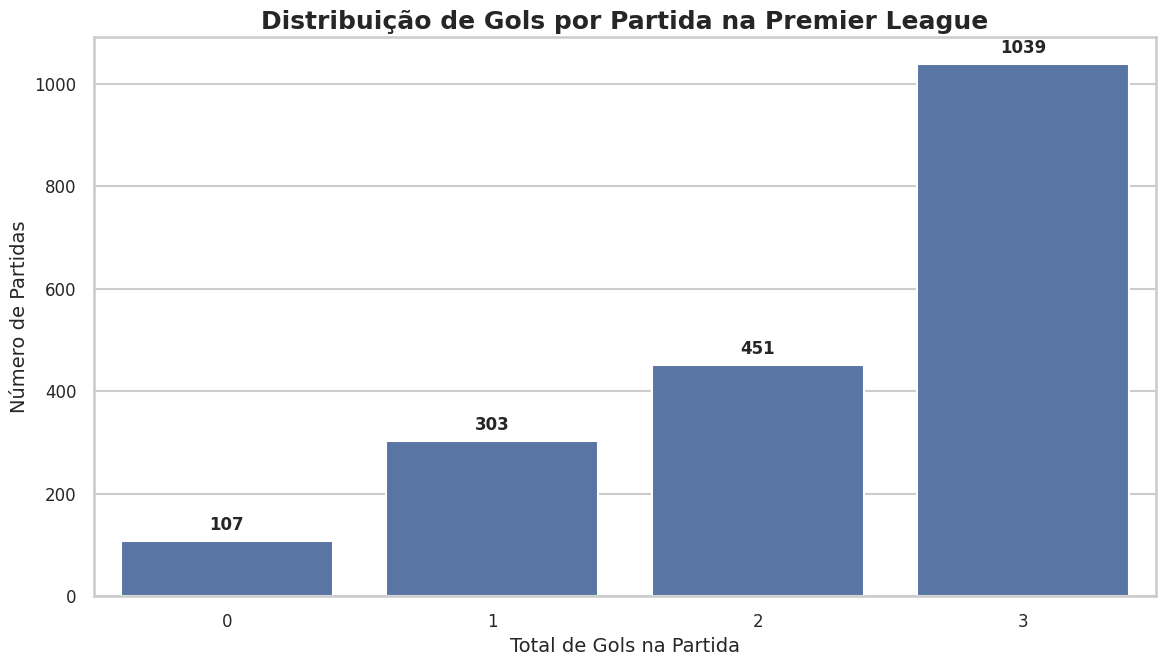

In [ ]:
# Configurações de estilo
sns.set(style="whitegrid", context="talk", palette="deep")
# Contar número de partidas por total de gols
gols_counts = y.value_counts().sort_index()

# Criar o gráfico
plt.figure(figsize=(12, 7))
bars = sns.barplot(x=gols_counts.index, y=gols_counts.values)

# Adicionar valores no topo das barras
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5), textcoords='offset points',
                  ha='center', va='bottom', fontsize=12, fontweight='bold')

# Títulos e eixos
plt.title("Distribuição de Gols por Partida na Premier League", fontsize=18, fontweight='bold')
plt.xlabel("Total de Gols na Partida", fontsize=14)
plt.ylabel("Número de Partidas", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Exibir gráfico
plt.show()

In [ ]:
y.value_counts()

,count
goal_class,
3,1039
2,451
1,303
0,107


## 5.2 - **Balancemento**

Aplicou-se a técnica SMOTE (Synthetic Minority Over-sampling Technique) para balancear as classes da variável-alvo (goal_class). Essa abordagem gera amostras sintéticas das classes minoritárias, reduzindo o desequilíbrio e contribuindo para um melhor desempenho dos modelos preditivos

In [ ]:
# SMOTE para multi-class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

### 5.2.1 - **Distribuição das classes após o balanceamento (SMOTE)**


O gráfico de barras abaixo mostra a nova distribuição das classes da variável goal_class após a aplicação do SMOTE. Observa-se que as quatro faixas de gols passaram a ter o mesmo número de amostras, corrigindo o desbalanceamento original e promovendo condições mais justas para o treinamento dos modelos de classificação.

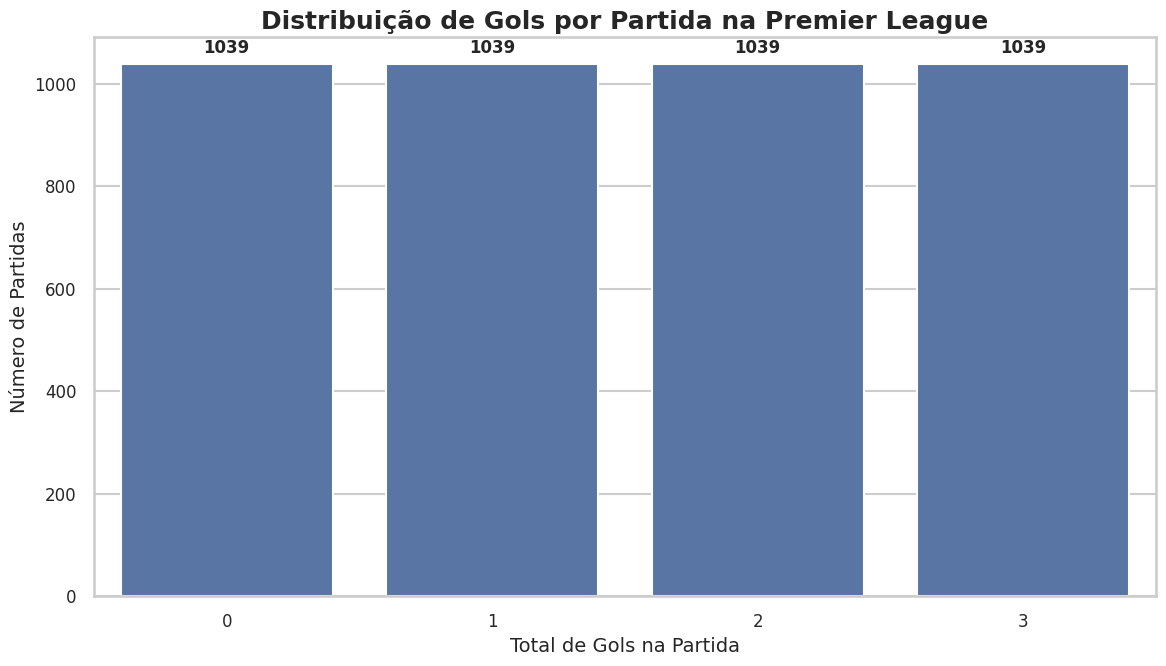

In [ ]:
# Configurações de estilo
sns.set(style="whitegrid", context="talk", palette="deep")
# Contar número de partidas por total de gols
gols_counts = y_resampled.value_counts().sort_index()

# Criar o gráfico
plt.figure(figsize=(12, 7))
bars = sns.barplot(x=gols_counts.index, y=gols_counts.values)

# Adicionar valores no topo das barras
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5), textcoords='offset points',
                  ha='center', va='bottom', fontsize=12, fontweight='bold')

# Títulos e eixos
plt.title("Distribuição de Gols por Partida na Premier League", fontsize=18, fontweight='bold')
plt.xlabel("Total de Gols na Partida", fontsize=14)
plt.ylabel("Número de Partidas", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Exibir gráfico
plt.show()

In [ ]:
y_resampled.value_counts()

,count
goal_class,
3,1039
2,1039
0,1039
1,1039


# 6. **Divisão dos dados em treino e teste**
Os dados balanceados foram divididos em conjuntos de treino (80%) e teste (20%) utilizando a função train_test_split. Foi aplicado o parâmetro stratify para garantir que a proporção das classes seja mantida em ambos os conjuntos, o que é essencial em problemas multiclasse.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

## 6.1 - **Avaliação dos modelos preditivos**
A função avaliar_modelos_x() automatiza o processo de avaliação comparativa entre diferentes algoritmos de classificação. Para cada modelo informado:

Realiza validação cruzada com 5 dobras (cross-validation) no conjunto de treino

Treina o modelo nos dados de treino

Avalia o desempenho nos dados de teste, gerando as seguintes métricas:

- Acurácia média na validação cruzada

- Acurácia no teste

- Recall (macro)

- F1-score (macro)

- ROC-AUC multiclasse (método "One-vs-Rest")


Exibe o relatório de classificação e a matriz de confusão para análise visual dos acertos e erros;

Organiza os resultados em uma tabela ordenada pelo F1-score.

In [ ]:
def avaliar_modelos_x(modelos, X_train, y_train, X_test, y_test, class_names=None):
    resultados = []

    # Binariza as classes verdadeiras para ROC-AUC multiclasse
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    for nome, modelo in modelos.items():
        print(f"\n📌 Treinando modelo: {nome}")

        # Validação cruzada
        scores_cv = cross_val_score(modelo, X_train, y_train, cv=5, scoring='accuracy')
        acuracia_cv = scores_cv.mean()

        # Treinamento
        modelo.fit(X_train, y_train)

        # Predição e avaliação
        y_pred = modelo.predict(X_test)
        y_proba = modelo.predict_proba(X_test)

        acuracia_teste = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

        # Relatório e matriz de confusão
        print(f"Acurácia média (validação cruzada): {acuracia_cv:.4f}")
        print(f"Acurácia no conjunto de teste: {acuracia_teste:.4f}")
        print(f"Recall (macro): {recall:.4f}")
        print(f"F1-score (macro): {f1:.4f}")
        print(f"ROC-AUC (macro-ovr): {roc_auc:.4f}")
        print("📊 Relatório de Classificação:")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Matriz de Confusão - {nome}')
        plt.xlabel('Classe Predita')
        plt.ylabel('Classe Real')
        plt.tight_layout()
        plt.show()

        # Armazenar resultados
        resultados.append({
            "Modelo": nome,
            "Acurácia Média CV": acuracia_cv,
            "Acurácia Teste": acuracia_teste,
            "Recall (macro)": recall,
            "F1-score (macro)": f1,
            "ROC-AUC (macro-ovr)": roc_auc
        })

    # Criar DataFrame final
    resultados_df = pd.DataFrame(resultados).sort_values(by="F1-score (macro)", ascending=False).reset_index(drop=True)

    print("\n✅ Tabela de Resultados Finais:")
    display(resultados_df)

    return resultados_df

## 6.2 - **Treinamento e avaliação dos modelos**
Foram definidos três modelos de classificação multiclasse para prever a faixa de gols por partida:

- Regressão Logística

- Random Forest

- XGBoost

Cada modelo foi avaliado com base na acurácia, recall, F1-score e ROC-AUC. Os resultados foram gerados pela função avaliar_modelos_x() e organizados em uma tabela comparativa.


📌 Treinando modelo: Logistic Regression
Acurácia média (validação cruzada): 0.6393
Acurácia no conjunto de teste: 0.6526
Recall (macro): 0.6526
F1-score (macro): 0.6415
ROC-AUC (macro-ovr): 0.8709
📊 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.71      0.93      0.81       208
           1       0.59      0.50      0.54       208
           2       0.52      0.45      0.48       208
           3       0.74      0.74      0.74       208

    accuracy                           0.65       832
   macro avg       0.64      0.65      0.64       832
weighted avg       0.64      0.65      0.64       832



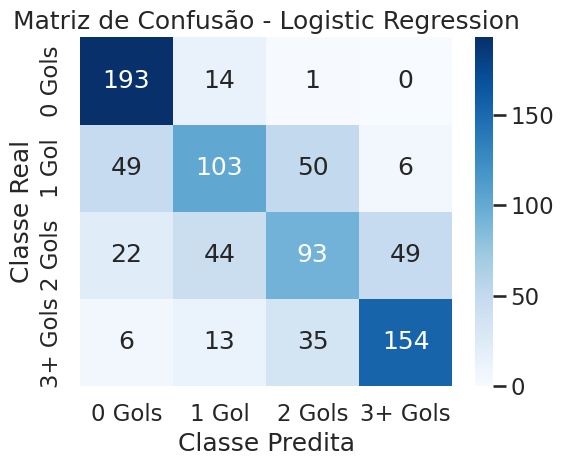


📌 Treinando modelo: Random Forest
Acurácia média (validação cruzada): 0.8324
Acurácia no conjunto de teste: 0.8762
Recall (macro): 0.8762
F1-score (macro): 0.8748
ROC-AUC (macro-ovr): 0.9751
📊 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       208
           1       0.88      0.89      0.89       208
           2       0.88      0.75      0.81       208
           3       0.81      0.87      0.84       208

    accuracy                           0.88       832
   macro avg       0.88      0.88      0.87       832
weighted avg       0.88      0.88      0.87       832



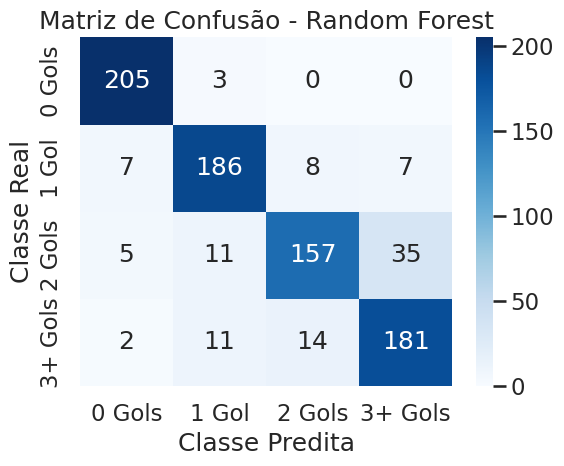


📌 Treinando modelo: XGBoost
Acurácia média (validação cruzada): 0.8192
Acurácia no conjunto de teste: 0.8558
Recall (macro): 0.8558
F1-score (macro): 0.8542
ROC-AUC (macro-ovr): 0.9695
📊 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       208
           1       0.87      0.86      0.86       208
           2       0.85      0.73      0.79       208
           3       0.77      0.84      0.80       208

    accuracy                           0.86       832
   macro avg       0.86      0.86      0.85       832
weighted avg       0.86      0.86      0.85       832



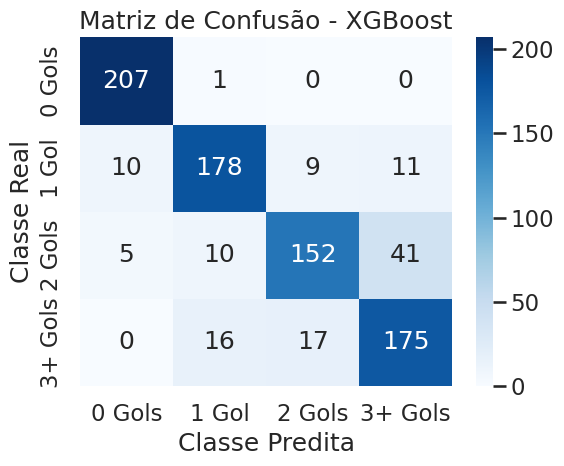


✅ Tabela de Resultados Finais:


,Modelo,Acurácia Média CV,Acurácia Teste,Recall (macro),F1-score (macro),ROC-AUC (macro-ovr)
0,Random Forest,0.832433,0.876202,0.876202,0.874823,0.975103
1,XGBoost,0.819197,0.855769,0.855769,0.854235,0.969538
2,Logistic Regression,0.639288,0.652644,0.652644,0.641507,0.870868


In [ ]:
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

tabela_resultados = avaliar_modelos_x(modelos, X_train, y_train, X_test, y_test, class_names=["0 Gols", "1 Gol", "2 Gols", "3+ Gols"])

# 7. **Transformação da tabela de resultados para formato longo**
Para facilitar a visualização comparativa entre os modelos, a tabela de métricas foi reorganizada para o formato long com pd.melt(). Foram selecionadas quatro métricas principais:

Acurácia no teste

Recall (macro)

F1-score (macro)

ROC-AUC (macro-ovr)

O resultado é um novo DataFrame (detailed_metrics) com três colunas: Modelo, Métrica e Valor, pronto para ser usado em gráficos comparativos.

In [ ]:
# Selecionar colunas desejadas e transformar para formato longo
metricas_selecionadas = ["Acurácia Teste", "Recall (macro)", "F1-score (macro)", "ROC-AUC (macro-ovr)"]

detailed_metrics = tabela_resultados.melt(
    id_vars="Modelo",
    value_vars=metricas_selecionadas,
    var_name="Métrica",
    value_name="Valor"
)

# 8. **Comparação visual entre os modelos**
O gráfico abaixo compara o desempenho dos três modelos avaliados (Random Forest, XGBoost e Regressão Logística) nas principais métricas: Acurácia, F1-score, Recall e ROC-AUC. A visualização facilita a identificação do modelo com melhor desempenho geral, destacando a superioridade da Random Forest em todas as métricas analisadas.

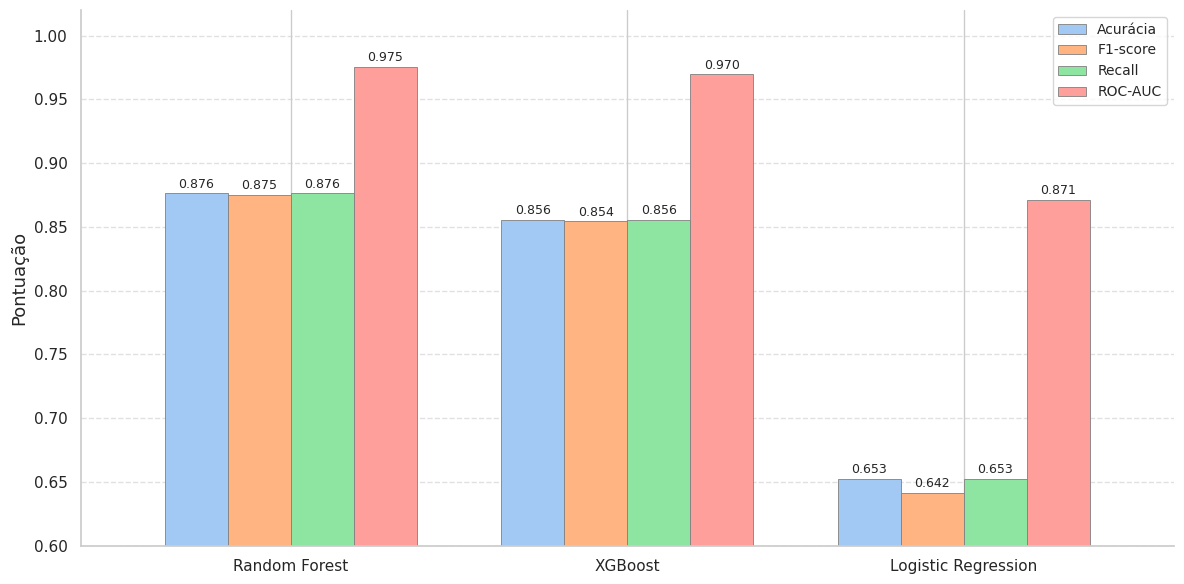

In [ ]:
# Dados
df_resultados = pd.DataFrame({
    "Modelo": ["Random Forest", "XGBoost", "Logistic Regression"],
    "Acurácia": [0.876202, 0.855769, 0.652644],
    "F1-score": [0.874823, 0.854235, 0.641507],
    "Recall": [0.876202, 0.855769,  0.652644],
    "ROC-AUC": [0.975103, 0.969538, 0.870868]
}).set_index("Modelo")

# Estilo profissional e paleta pastel
sns.set_theme(style="whitegrid")
pastel_palette = sns.color_palette("pastel")

# Criar o gráfico de barras
ax = df_resultados.plot(
    kind="bar",
    color=pastel_palette,
    width=0.75,
    edgecolor='gray',
    linewidth=0.6,
    figsize=(12, 6)
)

# Ajustes estéticos
ax.set_ylabel("Pontuação", fontsize=13)
ax.set_xlabel("")
ax.set_ylim(0.60, 1.02)
ax.set_xticklabels(df_resultados.index, rotation=0, fontsize=11)
ax.legend(loc="upper right", fontsize=10, title=None)
ax.grid(axis="y", linestyle="--", alpha=0.6)
sns.despine()

# Adicionar os valores no topo das barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', padding=2, fontsize=9)

plt.tight_layout()
plt.show()

# 9. **Conclusão**
O presente trabalho demonstrou que é viável prever faixas de gols em partidas da Premier League utilizando técnicas de aprendizado de máquina, a partir de dados estatísticos agregados. Entre os modelos avaliados, o Random Forest se destacou, atingindo desempenho superior em todas as métricas — com destaque para um ROC-AUC de 0,98, indicando excelente capacidade discriminativa entre as classes. O XGBoost também obteve resultados robustos, embora ligeiramente inferiores, enquanto a Regressão Logística, apesar de sua simplicidade e interpretabilidade, apresentou limitações na captura de padrões não lineares.